In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import itertools
import heapq

In [ ]:
# https://digitology.tech/docs/python_3/library/heapq.html
class PriorityQueue:
    def __init__(self):
        self.queue = []
        self.data = {}
        self.position = itertools.count()

    def insert(self, key, priority):
        if key in self.data:
            self.remove(key)
        pos = next(self.position)
        entry = [priority, pos, key]
        self.data[key] = entry
        heapq.heappush(self.queue, entry)

    def remove(self, key):
        if key not in self.data:
            raise KeyError(f"Key '{key}' not found in priority queue")
        entry = self.data.pop(key)
        entry[-1] = None

    def decrease(self, key, priority):
        self.remove(key)
        self.insert(key, priority)

    def pop(self):
        while self.queue:
            priority, id, key = heapq.heappop(self.queue)
            if key is not None:
                del self.data[key]
                return key
        if not self.data:
            # print("no data")
            return None

In [ ]:
class MYOPTICS(object):
    def __init__(self, points, epsilon = np.inf, minPts = 30):
        self.SetOfObjects = points
        n = self.SetOfObjects.shape[0]
        self.processed  = np.array([False] * n)
        self.reachability_distances = np.array([np.inf] * n)
        self.core_distances = np.array([np.inf] * n)
        self.epsilon = epsilon
        self.minPts = minPts
        self.ordered_points = []
        self.order_seeds = PriorityQueue()
        self.KDtree = spatial.cKDTree(self.SetOfObjects)
        self.labels = np.array([-1] * n)

    def optics(self):
        data = self.SetOfObjects
        for i in range(len(data)):
            point = data[i]
            if not self.processed[i]:
                self.ExpandClusterOrder(point, i)

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html
    def setCoreDistance(self, point, neighboursIdx):
        if len(neighboursIdx) >= self.minPts:
            distances, _ = self.KDtree.query(x=point, k=[self.minPts-1])
            return distances

    def ExpandClusterOrder(self, point, pointIdx):
        # https://stackoverflow.com/questions/32424604/find-all-nearest-neighbors-within-a-specific-distance
        neighboursIdx = self.KDtree.query_ball_point(point, self.epsilon)
        self.processed[pointIdx] = True
        self.reachability_distances[pointIdx] = np.inf
        self.core_distances[pointIdx] = self.setCoreDistance(point, neighboursIdx)
        self.ordered_points.append(pointIdx)
        if not np.isposinf(self.core_distances[pointIdx]):
            self.OrderSeedsUpdate(neighboursIdx, point, pointIdx)
        while True:
            currentPointIdx = self.order_seeds.pop()
            if not currentPointIdx:
                break
            currentPoint = self.SetOfObjects[currentPointIdx]
            currentPointNeighboursIdx = self.KDtree.query_ball_point(currentPoint, self.epsilon)
            self.processed[currentPointIdx] = True
            self.core_distances[currentPointIdx] = self.setCoreDistance(currentPoint, currentPointNeighboursIdx)
            self.ordered_points.append(currentPointIdx)
            if not np.isposinf(self.core_distances[currentPointIdx]):
                self.OrderSeedsUpdate(currentPointNeighboursIdx, currentPoint, currentPointIdx)


    def OrderSeedsUpdate(self, neighboursIdx, CenterObject, CenterObjectIdx):
        c_dist = self.core_distances[CenterObjectIdx]
        for i in range(len(neighboursIdx)):
            neighbour_idx = neighboursIdx[i]
            neighbour = self.SetOfObjects[neighbour_idx]
            if not self.processed[neighbour_idx]:
                new_r_dist = max(c_dist, np.linalg.norm(neighbour - CenterObject))
                if np.isposinf(self.reachability_distances[neighbour_idx]):
                    self.reachability_distances[neighbour_idx] = new_r_dist
                    self.order_seeds.insert(neighbour_idx, priority=new_r_dist)
                elif new_r_dist < self.reachability_distances[neighbour_idx]:
                    self.reachability_distances[neighbour_idx] = new_r_dist
                    self.order_seeds.decrease(neighbour_idx, priority=new_r_dist)


    def ExtractDBSCANClustering(self, new_eps):
        clusterID = 0
        for point in self.ordered_points:
            r_dist = self.reachability_distances[point]
            c_dist = self.core_distances[point]
            if r_dist > new_eps:
                if c_dist <= new_eps:
                    clusterID += 1
                    self.labels[point] = clusterID
                else:
                    self.labels[point] = -1
            else:
                self.labels[point] = clusterID
        return self.labels


    def draw_reachability_plot(self):
        reachability_distances = [self.reachability_distances[index] for index in self.ordered_points]
        fig = plt.figure()
        plt.plot(range(len(reachability_distances)), reachability_distances)
        plt.title("Reachability plot")
        plt.xlabel('Ordered Points')
        plt.ylabel('Reachability Distances')
        plt.show()

    def plot_clusters(self):
        fig = plt.figure()
        for i in range(-1, len(set(self.labels))):
            subCluster = self.SetOfObjects[np.where(self.labels == i)]
            plt.scatter(subCluster[:, 0], subCluster[:, 1], s=10)
        plt.title("Clusters")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()


## ExtractClusters

In [ ]:
class SteepDownArea:
    def __init__(self, begin, end):
        self.begin = begin
        self.end = end
        self.mib = 0

    def to_arr(self):
        return [self.begin, self.end, self.mib]

class ExtractClusters:
    def __init__(self, reachability, order, minPts, eps):
        self.reachability = np.array([reachability[index] for index in order])
        self.minPts = minPts
        self.eps = eps
    def is_steep_up_point(self, index):
        return (index + 1 < self.reachability.shape[0] and
                self.reachability[index] <= self.reachability[index + 1] * (1 - self.eps))

    def is_steep_down_point(self, index):
        return (index + 1 < self.reachability.shape[0] and
                self.reachability[index] * (1 - self.eps) >= self.reachability[index + 1])

    def find_steep_up_area(self, index):
        # index should be steep up point
        begin = index
        n = self.reachability.shape[0]
        end = begin + 1
        not_steep_count = 0
        last_steep = begin
        while end < n and self.reachability[end - 1] <= self.reachability[end]:
            if self.is_steep_up_point(end):
                not_steep_count = 0
                last_steep = end
            else:
                not_steep_count += 1
            if not_steep_count > self.minPts:
                break
            end += 1
        end = last_steep
        return begin, end


    def find_steep_down_area(self, index):
        # index should be steep down point
        begin = index
        n = self.reachability.shape[0]
        end = begin + 1
        not_steep_count = 0
        last_steep = begin
        while end < n and self.reachability[end - 1] >= self.reachability[end]:
            if self.is_steep_down_point(end):
                not_steep_count = 0
                last_steep = end
            else:
                not_steep_count += 1
            if not_steep_count > self.minPts:
                break
            end += 1
        end = last_steep
        return begin, end

    def filter_set_of_steep_down_areas_and_update_mibs(self, set_of_steep_down_areas, mib):
        i = 0
        while i < len(set_of_steep_down_areas):
            area = set_of_steep_down_areas[i]
            area.mib = max(area.mib, mib)
            if self.reachability[area.begin] * (1 - self.eps) < mib:
                set_of_steep_down_areas.pop(i)
            else:
                i += 1

    def extract_clusters(self):
        set_of_steep_down_areas = []
        set_of_clusters = []
        index = 0
        mib = 0
        n = self.reachability.shape[0]
        while index < n:
            mib = max(mib, self.reachability[index])
            if self.is_steep_down_point(index):
                begin, end = self.find_steep_down_area(index)
                self.filter_set_of_steep_down_areas_and_update_mibs(set_of_steep_down_areas, mib)
                set_of_steep_down_areas.append(SteepDownArea(begin, end))
                index = end + 1
                mib = self.reachability[index]
            elif self.is_steep_up_point(index):
                self.filter_set_of_steep_down_areas_and_update_mibs(set_of_steep_down_areas, mib)
                begin, end = self.find_steep_up_area(index)
                for area in set_of_steep_down_areas:
                    if  area.mib <= self.reachability[end] * (1 - self.eps) and end - area.begin >= optics.minPts:
                        s, e = area.begin, end
                        if self.reachability[s] * (1 - self.eps) >= self.reachability[e + 1]:
                            for i in range(area.end, area.begin, -1):
                                if self.reachability[i] > self.reachability[e + 1]:
                                    s = i
                                    break
                        elif self.reachability[s] <= self.reachability[e + 1] * (1 - self.eps):
                            for i in range(end, begin, -1):
                                if self.reachability[i] < self.reachability[s]:
                                    e = i
                                    break
                        set_of_clusters.append([s, e])
                index = end + 1
                mib = self.reachability[index - 1]
            else:
                index += 1
        return set_of_clusters


    def plot_clusters(self):
        clusters = sorted(self.extract_clusters(),
                          key = lambda x: x[1] - x[0], reverse = True)
        cluster_structure = [[]]
        fig = plt.figure()
        for new_cl in clusters:
            finded = False
            for i in range(len(cluster_structure)):
                for cl in cluster_structure[i]:
                    if cl[0] <= new_cl[0] and new_cl[1] <= cl[1]:
                        if i == 0:
                            cluster_structure.insert(0, [])
                            i = 1
                        cluster_structure[i - 1].append([new_cl[0], new_cl[1], False])
                        finded = True
                        break
                if finded:
                    break
            if not finded:
                cluster_structure[-1].append([new_cl[0], new_cl[1], False])
        for i in range(len(cluster_structure)):
            cluster_structure[i] = sorted(cluster_structure[i], key = lambda x: x[0])
            for j in range(1, len(cluster_structure[i])):
                if cluster_structure[i][j][0] - cluster_structure[i][j - 1][1] < 10 and not cluster_structure[i][j - 1][2]:
                    cluster_structure[i][j][2] = True
        ax = None
        for i in range(len(cluster_structure)):
            for cl in cluster_structure[i]:
                if cl[2]:
                    ax = plt.axhline(y = -0.05 * (i + 1) - 0.025, xmin = (cl[0] + 10) / (len(self.reachability) + 20),
                                xmax = (cl[1] + 10) / (len(self.reachability) + 20), color='black')
                else:
                    ax = plt.axhline(y = -0.05 * (i + 1), xmin = (cl[0] + 10) / (len(self.reachability) + 20),
                                xmax = (cl[1] + 10) / (len(self.reachability) + 20), color='black')
        ax.set_label("Clusters")
        plt.plot(range(len(self.reachability)), self.reachability, label="Reachability plot")
        plt.title("Reachability plot with clusters")
        plt.xlabel('Ordered Points')
        plt.ylabel('Reachability Distances')
        plt.xlim([-10, len(self.reachability) + 10])
        plt.legend()
        plt.show()

## [Dataset](https://www.kaggle.com/datasets/samuelcortinhas/2d-clustering-data?select=data.csv)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('data.csv')
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

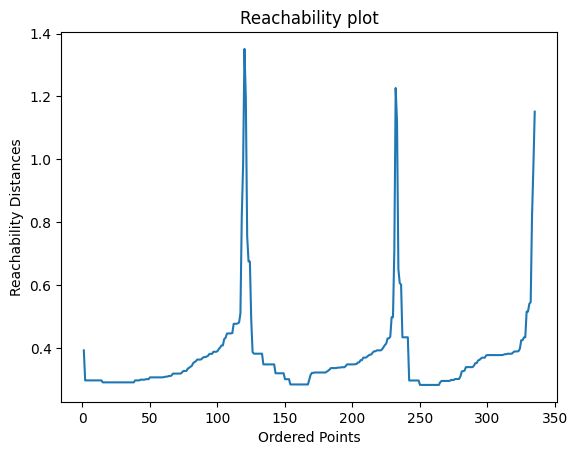

In [ ]:
optics = MYOPTICS(df_scaled, epsilon = np.inf, minPts = 25)
optics.optics()
optics.draw_reachability_plot()

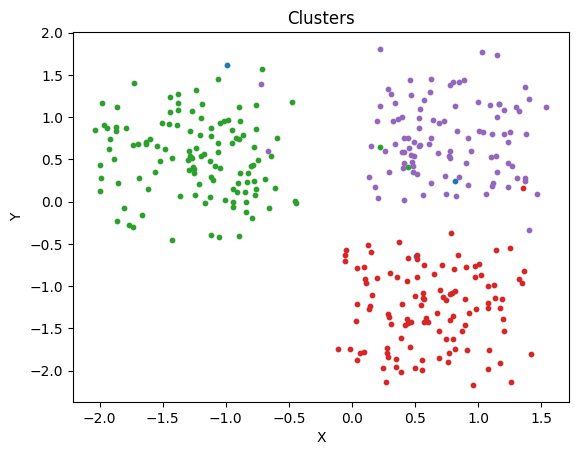

In [ ]:
clusters = optics.ExtractDBSCANClustering(1)
optics.plot_clusters()

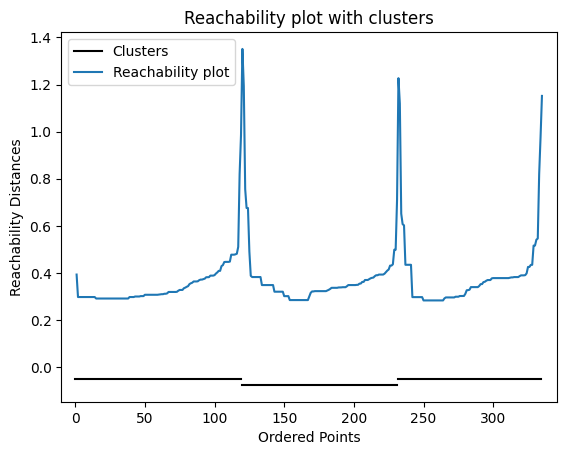

In [ ]:
ext_cl = ExtractClusters(optics.reachability_distances, optics.ordered_points, optics.minPts, 0.05)
ext_cl.plot_clusters()

## Test

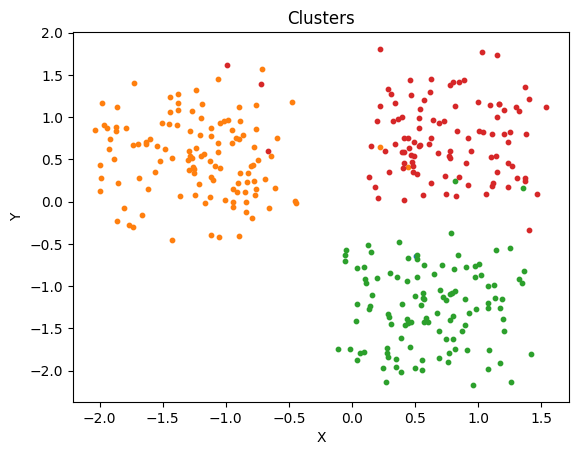

In [ ]:
from sklearn.cluster import OPTICS
def plot_clusters(data, labels):
    fig = plt.figure()
    for i in range(-1, len(set(labels))):
        subCluster = data[np.where(labels == i)]
        plt.scatter(subCluster[:, 0], subCluster[:, 1], s=10)
    plt.title("Clusters")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
clustering = OPTICS(min_samples=25).fit(df_scaled)
plot_clusters(df_scaled,clustering.labels_)